# Vehicle Performance Prediction

This notebook analyzes vehicle performance data and builds several predictive models using scikit-learn and PyTorch to predict various performance metrics.

We'll explore the following targets for prediction:
1. Lap time
2. Fuel consumption
3. Average speed

And we'll use the following algorithms:
- Linear Regression
- GaussianProcessRegressor
- Decision Tree Regressor
- RandomForestRegressor
- GradientBoostingRegressor
- Support Vector Regressor
- PyTorch Neural Network

## 1. Import Libraries

In [119]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression algorithms
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For visualization
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 2. Data Explore

In [120]:
df = pd.read_csv('Data.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
df.head()
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

Dataset shape: (8500, 53)
Missing values:
No missing values


In [121]:
# Statistical summary
df.describe()

,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,velocity,lap time,lap,mass,drag_coefficient,...,rear_left_wheel_position_z,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,rear_right_wheel_position_x,rear_right_wheel_position_y,rear_right_wheel_position_z
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.00000,8500.000000,8500.000000,...,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.00000,8500.000000,8500.000000,8500.000000,8500.000000
mean,15.300034,0.007070,212.980726,47.940750,5.625210,4.561819,44.098026,250.50000,1983.941176,0.320588,...,86.249518,37.411765,1294.117647,2588.235294,2.941176,18.00000,2235.294118,-829.983130,4428.750294,86.249529
std,0.570637,0.006269,50.565260,9.152733,4.022636,1.031912,1.818907,144.34577,2278.491606,0.066555,...,5.988813,8.326981,694.108626,1388.217252,1.258953,1.78237,1058.885819,6294.228371,4994.571742,5.988818
min,13.603687,0.000248,120.460764,29.005589,0.534571,2.352162,38.703337,1.00000,140.000000,0.250000,...,73.714622,21.500000,400.000000,800.000000,1.000000,15.00000,1000.000000,-11518.075195,-5643.188477,73.714622
25%,14.931055,0.003310,171.702386,42.078381,2.772816,3.804269,42.696987,125.75000,1105.000000,0.300000,...,84.157211,33.500000,800.000000,1600.000000,2.000000,17.00000,1000.000000,-5287.428711,1593.346680,84.157211
50%,15.441523,0.005387,192.574367,45.391252,3.915343,4.378021,43.953436,250.50000,1410.000000,0.300000,...,86.128242,35.000000,1500.000000,3000.000000,3.000000,17.00000,3000.000000,-1688.020142,2868.444824,86.128242
75%,15.705991,0.007650,259.164424,53.116344,7.515535,5.171643,45.153419,375.25000,1920.000000,0.300000,...,89.066559,37.500000,1500.000000,3000.000000,3.000000,20.00000,3000.000000,3398.295166,6962.188965,89.066559
max,16.862017,0.031828,302.456161,77.616349,20.134363,7.481782,49.688994,500.00000,10000.000000,0.500000,...,98.503029,57.000000,3000.000000,6000.000000,5.000000,20.00000,4000.000000,10970.796875,13312.832031,98.503029


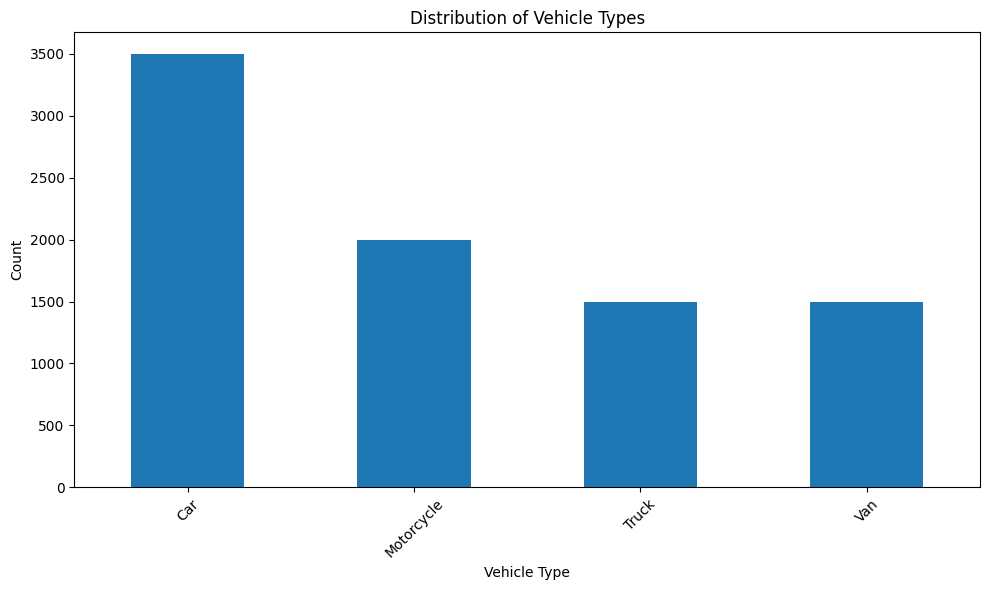

In [122]:
# Count of vehicle types
vehicle_counts = df['vehicle_type'].value_counts()
plt.figure(figsize=(10, 6))
vehicle_counts.plot(kind='bar')
plt.title('Distribution of Vehicle Types')
plt.ylabel('Count')
plt.xlabel('Vehicle Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [123]:
# Extract vehicle name brand for additional feature
df['vehicle_brand'] = df['vehicle_name'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else 'unknown')

# Normalize the vehicle fuel consumption from 0 - 1
# df['fuel_consumption'] = (df['fuel_consumption'] - df['fuel_consumption'].min()) / (df['fuel_consumption'].max() - df['fuel_consumption'].min()) 
df['fuel_consumption'] *=100

# Select features to keep
# We'll exclude vehicle_name as it's too specific, but keep vehicle_brand, vehicle_type, and track_type
features = ['vehicle_brand', 'vehicle_type', 'mass', 'drag_coefficient',
            'center_of_mass_x', 'center_of_mass_z', 'max_rpm', 'clutch_strength',
            'gear_switch_time', 'front_left_wheel_radius', 'front_left_wheel_max_brake_torque',
            'rear_right_wheel_radius', 'rear_right_wheel_max_brake_torque']

# Define our target variables
targets = ['lap time', 'fuel_consumption', 'average_speed']

# Function to preprocess data for a specific target
def preprocess_data(target):
    # Identify categorical and numerical features
    categorical_features = ['vehicle_brand', 'vehicle_type']
    numerical_features = [f for f in features if f not in categorical_features]
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Split the data
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features

## 4. Feature Correlation Analysis

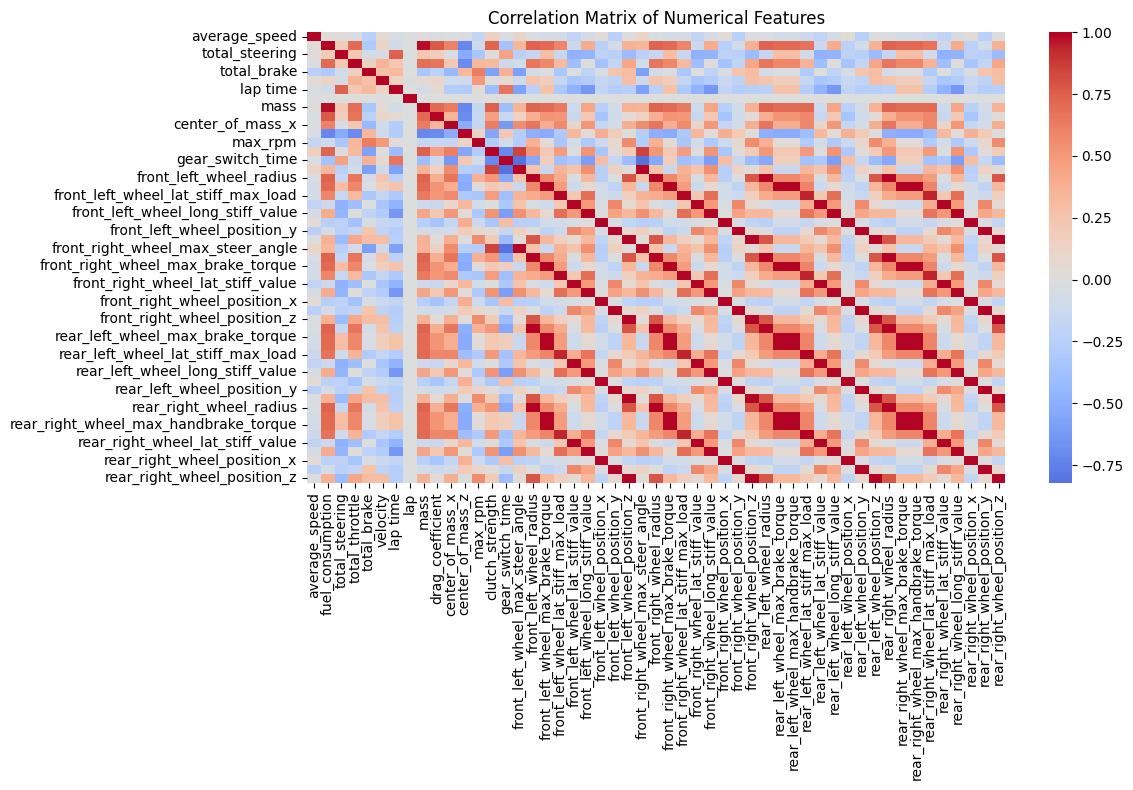


Correlation with lap time:
total_steering                           0.738071
gear_switch_time                         0.659730
total_brake                              0.313744
front_left_wheel_max_brake_torque        0.262974
rear_left_wheel_max_brake_torque         0.262974
rear_right_wheel_max_handbrake_torque    0.262974
rear_left_wheel_max_handbrake_torque     0.262974
rear_right_wheel_max_brake_torque        0.262974
front_right_wheel_max_brake_torque       0.262974
total_throttle                           0.231400
Name: lap time, dtype: float64

Correlation with fuel_consumption:
mass                                 0.977777
drag_coefficient                     0.770427
front_left_wheel_radius              0.734402
front_right_wheel_radius             0.734402
rear_left_wheel_radius               0.732831
rear_right_wheel_radius              0.732831
clutch_strength                      0.729534
rear_left_wheel_max_brake_torque     0.709159
front_left_wheel_max_brake_torque    

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure targets exist
if 'targets' not in locals() and 'targets' not in globals():
    raise ValueError("The variable 'targets' is not defined. Please define it as a list of target column names.")

# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Check if target columns exist in numerical columns
valid_targets = [t for t in targets if t in numerical_cols]
if not valid_targets:
    raise ValueError(f"None of the target columns {targets} are numeric or present in the DataFrame.")

# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Correlation with target variables
for target in valid_targets:
    print(f"\nCorrelation with {target}:")
    correlations = df[numerical_cols].corr()[target].sort_values(ascending=False)
    print(correlations[correlations.index != target].head(10))


## 5. Model Building Functions

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

def build_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor, target_name):
    """Build, hyper-tune, and evaluate all models for a specific target"""
    results = []
    
    # Define models and their hyperparameter grids
    model_params = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}  
        },
        'Decision Tree Regressor': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'model__max_depth': [3, 5, 10, None],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            }
        },
        'Random Forest Regressor': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'model__n_estimators': [100, 120, 200, 300],
                'model__max_depth': [5, 6, 10, 15],
                'model__min_samples_split': [2, 5],
                'model__min_samples_leaf': [1, 2]
            }
        },
        'Gradient Boosting Regressor': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'model__n_estimators': [100, 200],
                'model__learning_rate': [0.01, 0.1],
                'model__max_depth': [3, 5, 9]
            }
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'model__C': [0.1, 1, 10],
                'model__gamma': ['scale', 'auto'],
                'model__kernel': ['linear', 'rbf'],
                'model__epsilon': [0.1, 0.2, 0.5]
            }
        },
         'Gaussian Process Regressor': {
             'model': GaussianProcessRegressor(
         kernel=RBF(length_scale=np.ones(30)) + WhiteKernel(noise_level=1e-3),
         alpha=1e-6,
         random_state=42
         ),
         'params': {
         'model__kernel': [
             RBF(length_scale=np.ones(30)),
             ]
         }
         }
    }
    
    print(f"\n===== Target: {target_name} =====")
    
    # Train and evaluate each model
    for name, config in model_params.items():
        print(f"\nTuning and Training {name}...")
        
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', config['model'])])
        
        # Perform Grid Search
        grid_search = GridSearchCV(
            pipeline,
            param_grid=config['params'],
            cv=3,  # 3-fold cross-validation
            scoring='r2',  # Use R² as the scoring metric
            n_jobs=-1  # Use all available CPU cores
        )
        grid_search.fit(X_train, y_train)
        
        # Get the best model and evaluate it
        best_model = grid_search.best_estimator_
        result = evaluate_model(best_model, X_test, y_test, name)
        result['target'] = target_name
        result['best_params'] = grid_search.best_params_  # Save the best hyperparameters
        results.append(result)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        
        # For Random Forest and Gradient Boosting, analyze feature importance
        if name in ['Random Forest Regressor', 'Gradient Boosting Regressor']:
            analyze_feature_importance(best_model, X_train, name, target_name)
    
    return results

In [126]:
def evaluate_model(model, X_test, y_test, model_name):
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
        print(f"{model_name} Performance:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R² score: {r2:.4f}")
        return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2}


===== Target: lap time =====

Tuning and Training Linear Regression...
Linear Regression Performance:
  RMSE: 0.7387
  MAE: 0.4198
  R² score: 0.8322
Best parameters for Linear Regression: {}

Tuning and Training Decision Tree Regressor...
Decision Tree Regressor Performance:
  RMSE: 0.7387
  MAE: 0.4198
  R² score: 0.8322
Best parameters for Decision Tree Regressor: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}

Tuning and Training Random Forest Regressor...
Random Forest Regressor Performance:
  RMSE: 0.7394
  MAE: 0.4198
  R² score: 0.8319
Best parameters for Random Forest Regressor: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


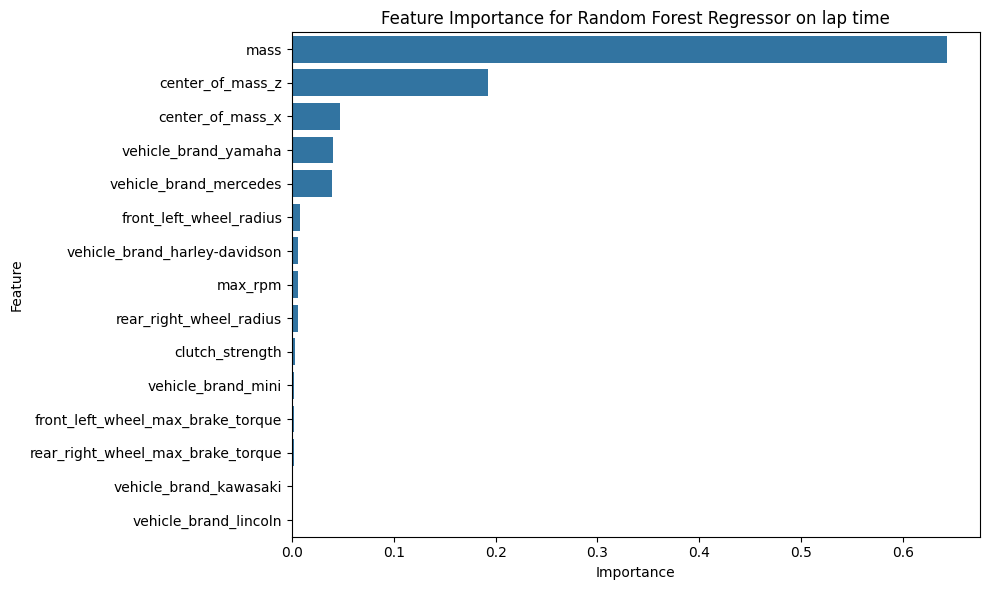

Top 10 features for Random Forest Regressor on lap time:
                          Feature  Importance
0                            mass    0.643242
3                center_of_mass_z    0.192346
2                center_of_mass_x    0.047415
25           vehicle_brand_yamaha    0.040791
18         vehicle_brand_mercedes    0.039139
7         front_left_wheel_radius    0.007665
15  vehicle_brand_harley-davidson    0.006365
4                         max_rpm    0.005944
9         rear_right_wheel_radius    0.005658
5                 clutch_strength    0.002689

Tuning and Training Gradient Boosting Regressor...
Gradient Boosting Regressor Performance:
  RMSE: 0.7387
  MAE: 0.4199
  R² score: 0.8323
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


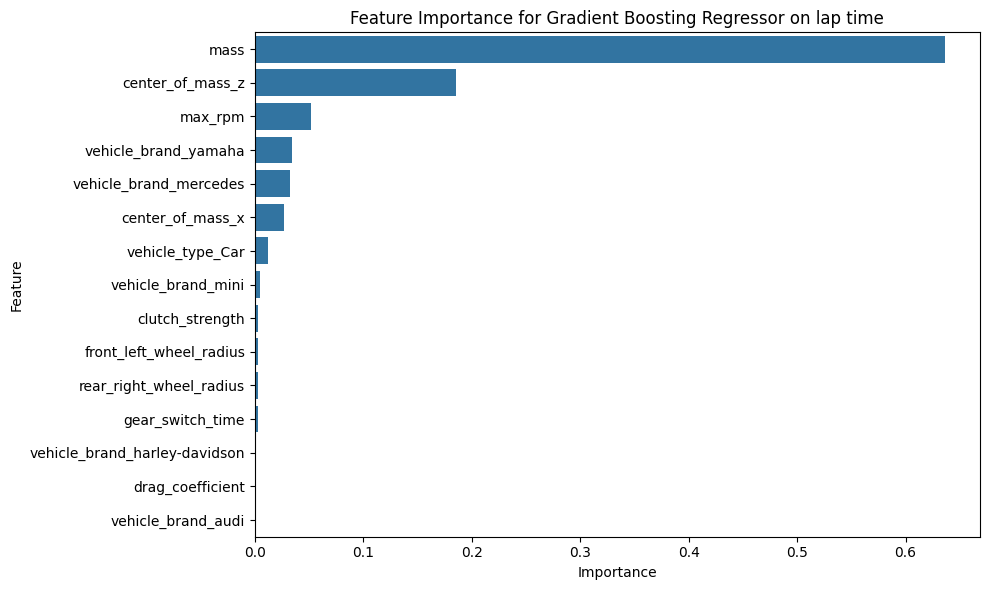

Top 10 features for Gradient Boosting Regressor on lap time:
                    Feature  Importance
0                      mass    0.636739
3          center_of_mass_z    0.185923
4                   max_rpm    0.051537
25     vehicle_brand_yamaha    0.033865
18   vehicle_brand_mercedes    0.032442
2          center_of_mass_x    0.027115
26         vehicle_type_Car    0.011762
19       vehicle_brand_mini    0.004779
5           clutch_strength    0.003406
7   front_left_wheel_radius    0.003184

Tuning and Training SVR...
SVR Performance:
  RMSE: 0.7456
  MAE: 0.4215
  R² score: 0.8291
Best parameters for SVR: {'model__C': 10, 'model__epsilon': 0.2, 'model__gamma': 'scale', 'model__kernel': 'linear'}

Tuning and Training Gaussian Process Regressor...
Gaussian Process Regressor Performance:
  RMSE: 0.7387
  MAE: 0.4198
  R² score: 0.8322
Best parameters for Gaussian Process Regressor: {'model__kernel': RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

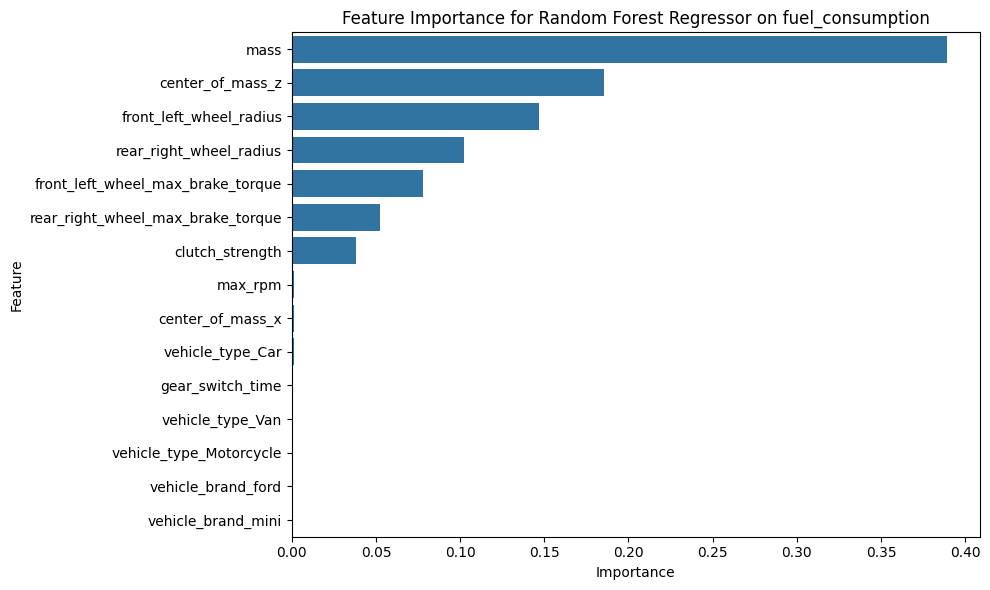

Top 10 features for Random Forest Regressor on fuel_consumption:
                              Feature  Importance
0                                mass    0.389318
3                    center_of_mass_z    0.185675
7             front_left_wheel_radius    0.146864
9             rear_right_wheel_radius    0.102214
8   front_left_wheel_max_brake_torque    0.077782
10  rear_right_wheel_max_brake_torque    0.052579
5                     clutch_strength    0.038257
4                             max_rpm    0.001433
2                    center_of_mass_x    0.001391
26                   vehicle_type_Car    0.001327

Tuning and Training Gradient Boosting Regressor...
Gradient Boosting Regressor Performance:
  RMSE: 0.0832
  MAE: 0.0641
  R² score: 0.9836
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


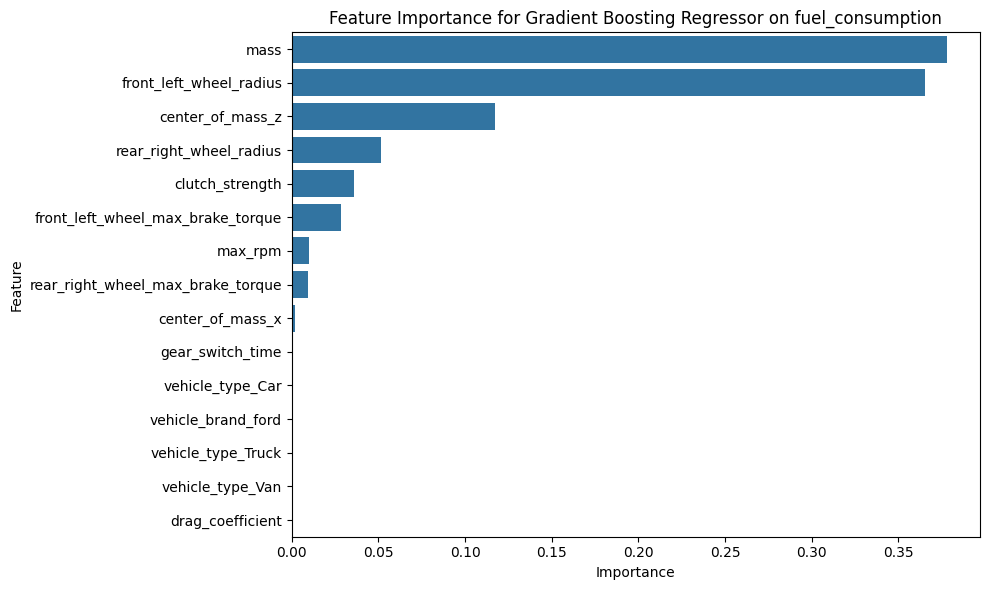

Top 10 features for Gradient Boosting Regressor on fuel_consumption:
                              Feature  Importance
0                                mass    0.378276
7             front_left_wheel_radius    0.365166
3                    center_of_mass_z    0.117180
9             rear_right_wheel_radius    0.051433
5                     clutch_strength    0.035790
8   front_left_wheel_max_brake_torque    0.028591
4                             max_rpm    0.009996
10  rear_right_wheel_max_brake_torque    0.009123
2                    center_of_mass_x    0.001586
6                    gear_switch_time    0.000823

Tuning and Training SVR...
SVR Performance:
  RMSE: 0.0862
  MAE: 0.0693
  R² score: 0.9824
Best parameters for SVR: {'model__C': 10, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

Tuning and Training Gaussian Process Regressor...


c:\Users\kfirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\kfirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 14 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian Process Regressor Performance:
  RMSE: 0.0832
  MAE: 0.0641
  R² score: 0.9836
Best parameters for Gaussian Process Regressor: {'model__kernel': RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

===== Target: average_speed =====

Tuning and Training Linear Regression...
Linear Regression Performance:
  RMSE: 0.4975
  MAE: 0.3833
  R² score: 0.2229
Best parameters for Linear Regression: {}

Tuning and Training Decision Tree Regressor...
Decision Tree Regressor Performance:
  RMSE: 0.4977
  MAE: 0.3835
  R² score: 0.2223
Best parameters for Decision Tree Regressor: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}

Tuning and Training Random Forest Regressor...
Random Forest Regressor Performance:
  RMSE: 0.4975
  MAE: 0.3832
  R² score: 0.2231
Best parameters for Random Forest Regressor: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_es

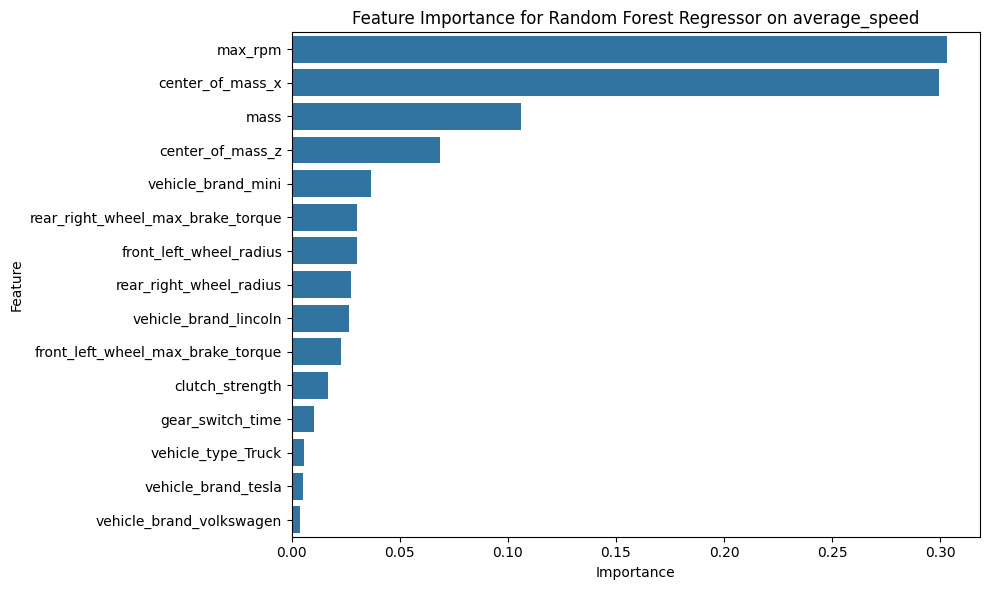

Top 10 features for Random Forest Regressor on average_speed:
                              Feature  Importance
4                             max_rpm    0.303260
2                    center_of_mass_x    0.299466
0                                mass    0.105919
3                    center_of_mass_z    0.068628
19                 vehicle_brand_mini    0.036597
10  rear_right_wheel_max_brake_torque    0.030389
7             front_left_wheel_radius    0.030334
9             rear_right_wheel_radius    0.027356
17              vehicle_brand_lincoln    0.026647
8   front_left_wheel_max_brake_torque    0.022644

Tuning and Training Gradient Boosting Regressor...
Gradient Boosting Regressor Performance:
  RMSE: 0.4975
  MAE: 0.3833
  R² score: 0.2229
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


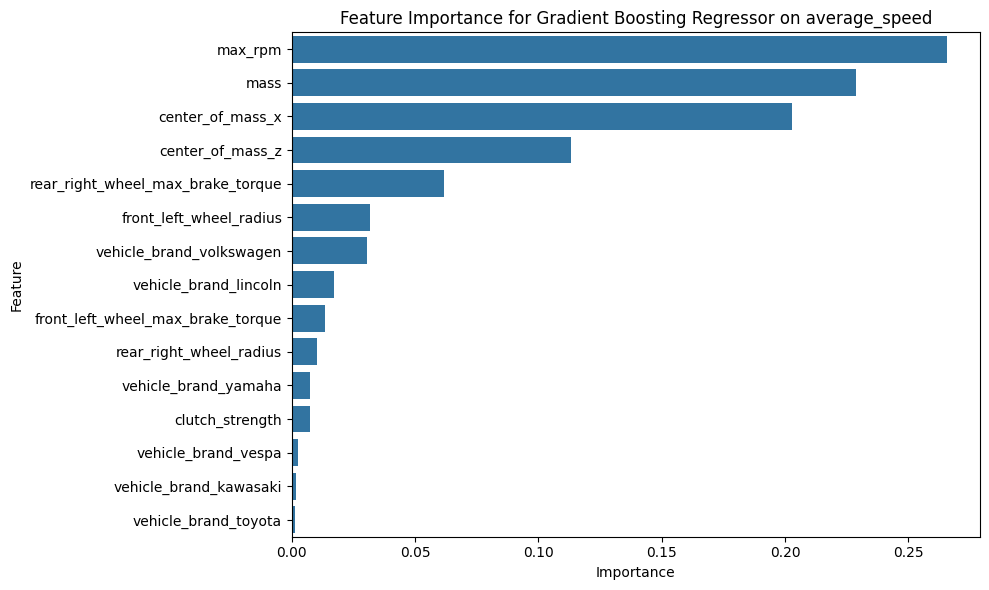

Top 10 features for Gradient Boosting Regressor on average_speed:
                              Feature  Importance
4                             max_rpm    0.265744
0                                mass    0.228702
2                    center_of_mass_x    0.202967
3                    center_of_mass_z    0.113248
10  rear_right_wheel_max_brake_torque    0.061762
7             front_left_wheel_radius    0.031850
24           vehicle_brand_volkswagen    0.030508
17              vehicle_brand_lincoln    0.017049
8   front_left_wheel_max_brake_torque    0.013514
9             rear_right_wheel_radius    0.010095

Tuning and Training SVR...
SVR Performance:
  RMSE: 0.4987
  MAE: 0.3840
  R² score: 0.2191
Best parameters for SVR: {'model__C': 0.1, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}

Tuning and Training Gaussian Process Regressor...
Gaussian Process Regressor Performance:
  RMSE: 0.4975
  MAE: 0.3833
  R² score: 0.2229
Best parameters for Gaussian Proce

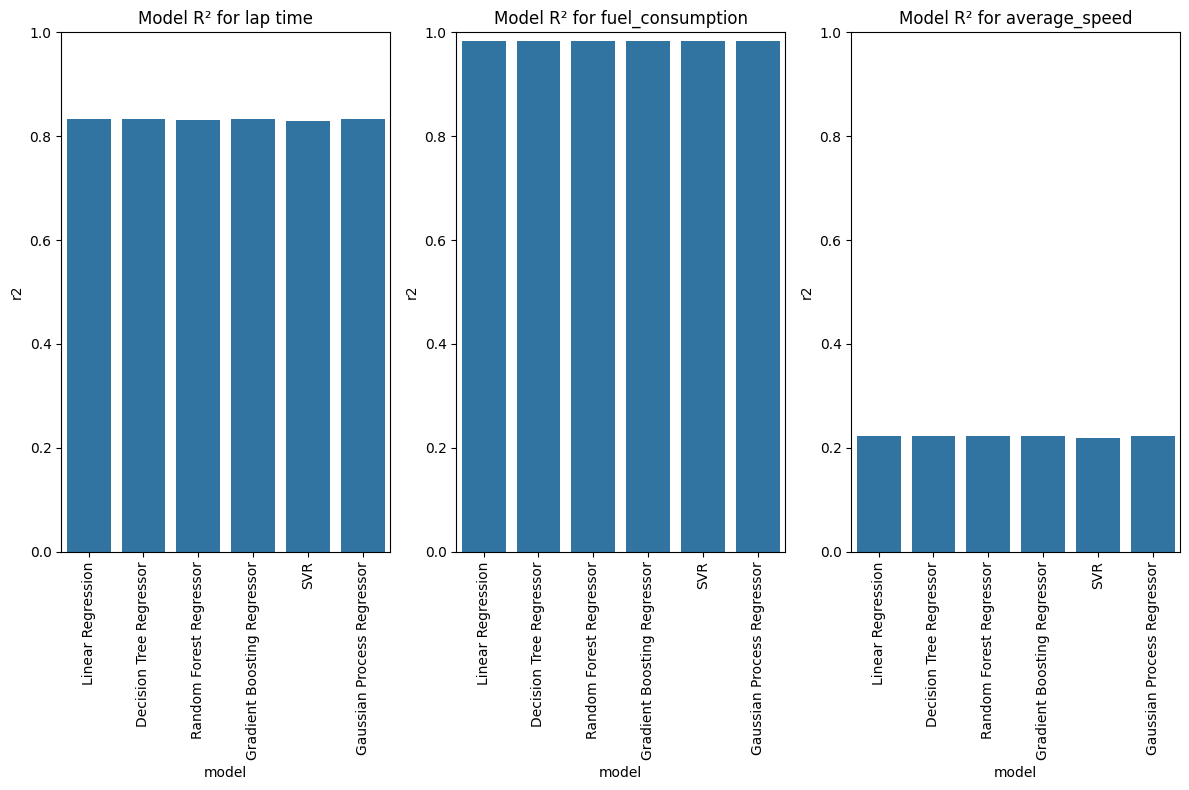


Best model for lap time: Gradient Boosting Regressor
  R² score: 0.8323
  RMSE: 0.7387

Best model for fuel_consumption: Gradient Boosting Regressor
  R² score: 0.9836
  RMSE: 0.0832

Best model for average_speed: Random Forest Regressor
  R² score: 0.2231
  RMSE: 0.4975


In [127]:
# First, define the analyze_feature_importance function
def analyze_feature_importance(pipeline, X_train, model_name, target_name):
    """Analyze and visualize feature importance for tree-based models"""
    # Get feature names after preprocessing
    categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns]
    numerical_features = [col for col in X_train.select_dtypes(exclude=['object']).columns]
    
    # Get the model from the pipeline
    model = pipeline.named_steps['model']
    
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Get feature names after one-hot encoding
        preprocessor = pipeline.named_steps['preprocessor']
        ohe = preprocessor.named_transformers_['cat']
        if hasattr(ohe, 'get_feature_names_out'):
            cat_features = ohe.get_feature_names_out(categorical_features)
        else:
            cat_features = [f"{col}_{val}" for col in categorical_features 
                           for val in ohe.categories_[categorical_features.index(col)]]
        
        feature_names = list(numerical_features) + list(cat_features)
        
        # Create DataFrame for importances
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top 15 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'Feature Importance for {model_name} on {target_name}')
        plt.tight_layout()
        plt.show()
        
        print(f"Top 10 features for {model_name} on {target_name}:")
        print(importance_df.head(10))
    else:
        print(f"Feature importance not available for {model_name}")

# Now use the functions to build and evaluate models for each target
all_results = []

for target in targets:
    # Preprocess data for this target
    X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features = preprocess_data(target)


    
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=5000, random_state=42)


    
    # Build and evaluate models
    results = build_and_evaluate_models(X_train_sample, X_test, y_train_sample, y_test, preprocessor, target)
    # results = build_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor, target)
    all_results.extend(results)

# Create a DataFrame with all results
results_df = pd.DataFrame(all_results)

# Visualize model performance across targets
plt.figure(figsize=(12, 8))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    target_results = results_df[results_df['target'] == target]
    sns.barplot(x='model', y='r2', data=target_results)
    plt.title(f'Model R² for {target}')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Find the best model for each target
for target in targets:
    target_results = results_df[results_df['target'] == target]
    best_model = target_results.loc[target_results['r2'].idxmax()]
    print(f"\nBest model for {target}: {best_model['model']}")
    print(f"  R² score: {best_model['r2']:.4f}")
    print(f"  RMSE: {best_model['rmse']:.4f}")

# Neural Network

## Neural network VehicleNN

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

class VehicleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.reshape(-1, 1))
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [129]:
# Define our neural network model
class VehicleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32, 16]):
        super(VehicleNN, self).__init__()
        
        # Create layers dynamically
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.Dropout(0.2))
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.Dropout(0.2))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [130]:
# Function to train the neural network
def train_nn(model, train_loader, val_loader, criterion, optimizer, device, epochs=100, patience=10):
    # Move model to device
    model.to(device)
    
    # For early stopping
    best_val_loss = float('inf')
    counter = 0
    
    # For tracking loss
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Forward pass
                outputs = model(X_batch)
                val_loss = criterion(outputs, y_batch)
                
                running_val_loss += val_loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return model, train_losses, val_losses

In [131]:
# Function to evaluate model performance
def evaluate_nn(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_targets = []
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)
    
    # Calculate metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    print(f"Neural Network Performance:")
    print(f"  Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Neural Network: Predicted vs Actual')
    plt.grid(True)
    plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [132]:
# Main function to prepare data and train the model
def nn_pipeline(data_path, target_name):
    # Load data
    df = pd.read_csv(data_path)
    
    # Add brand feature
    df['vehicle_brand'] = df['vehicle_name'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else 'unknown')
    df['fuel_consumption'] *= 100
    
    # Select features
    categorical_features = ['vehicle_brand', 'vehicle_type']
    numerical_features = ['mass', 'drag_coefficient', 'center_of_mass_x', 'center_of_mass_z', 
                         'max_rpm', 'clutch_strength', 'gear_switch_time', 
                         'front_left_wheel_radius', 'front_left_wheel_max_brake_torque',
                         'rear_right_wheel_radius', 'rear_right_wheel_max_brake_torque']
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Split data
    X = df[numerical_features + categorical_features]
    y = df[target_name].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Fit and transform data
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_val_transformed = preprocessor.transform(X_val)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Convert to PyTorch datasets
    train_dataset = VehicleDataset(X_train_transformed, y_train)
    val_dataset = VehicleDataset(X_val_transformed, y_val)
    test_dataset = VehicleDataset(X_test_transformed, y_test)
    
    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Get input size
    input_size = X_train_transformed.shape[1]
    
    # Initialize model
    model = VehicleNN(input_size=input_size)
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Train model
    model, train_losses, val_losses = train_nn(
        model, train_loader, val_loader, criterion, optimizer, device, epochs=200, patience=20
    )
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {target_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluate model
    results = evaluate_nn(model, test_loader, criterion, device)
    
    return model, preprocessor, results

Training NN for fuel_consumption prediction...
Using device: cuda
Epoch 1/200, Train Loss: 0.4270, Val Loss: 0.1118
Epoch 2/200, Train Loss: 0.1469, Val Loss: 0.0179
Epoch 3/200, Train Loss: 0.0898, Val Loss: 0.0126
Epoch 4/200, Train Loss: 0.0761, Val Loss: 0.0102
Epoch 5/200, Train Loss: 0.0630, Val Loss: 0.0089
Epoch 6/200, Train Loss: 0.0628, Val Loss: 0.0085
Epoch 7/200, Train Loss: 0.0618, Val Loss: 0.0088
Epoch 8/200, Train Loss: 0.0576, Val Loss: 0.0087
Epoch 9/200, Train Loss: 0.0595, Val Loss: 0.0087
Epoch 10/200, Train Loss: 0.0519, Val Loss: 0.0099
Epoch 11/200, Train Loss: 0.0514, Val Loss: 0.0111
Epoch 12/200, Train Loss: 0.0481, Val Loss: 0.0088
Epoch 13/200, Train Loss: 0.0508, Val Loss: 0.0089
Epoch 14/200, Train Loss: 0.0525, Val Loss: 0.0119
Epoch 15/200, Train Loss: 0.0501, Val Loss: 0.0128
Epoch 16/200, Train Loss: 0.0473, Val Loss: 0.0087
Epoch 17/200, Train Loss: 0.0456, Val Loss: 0.0083
Epoch 18/200, Train Loss: 0.0455, Val Loss: 0.0085
Epoch 19/200, Train Loss:

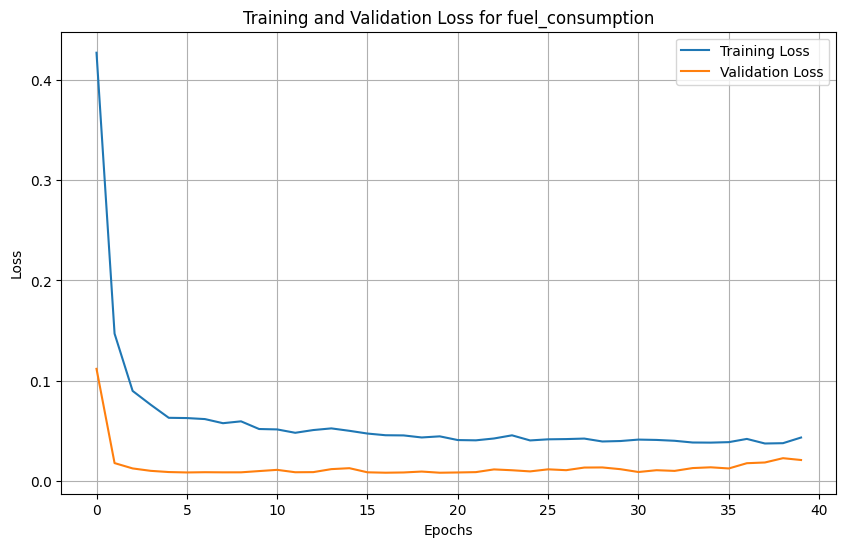

Neural Network Performance:
  Test Loss: 0.0084
  RMSE: 0.0923
  MAE: 0.0720
  R²: 0.9803


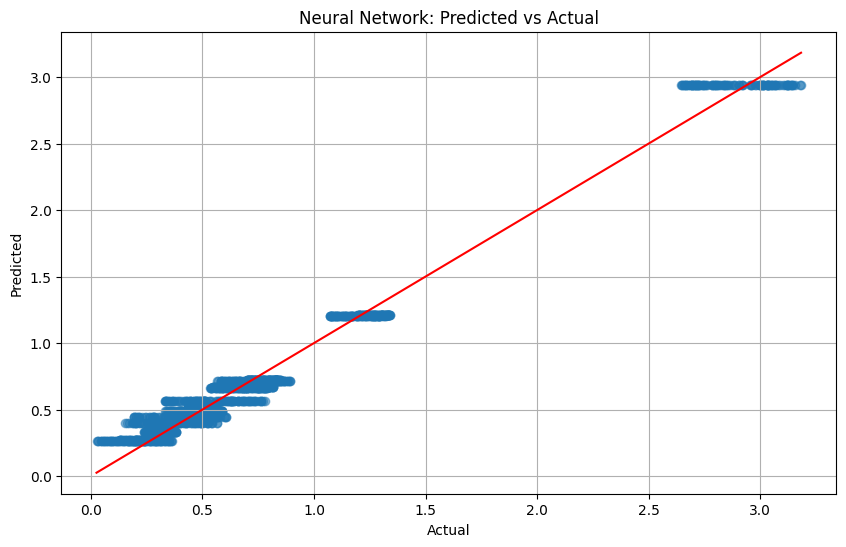

Results for fuel_consumption: {'rmse': np.float64(0.09230266889285166), 'mae': 0.07201460003852844, 'r2': 0.9802951812744141}
Training NN for lap time prediction...
Using device: cuda
Epoch 1/200, Train Loss: 1904.1292, Val Loss: 1841.2462
Epoch 2/200, Train Loss: 1763.4817, Val Loss: 1628.4661
Epoch 3/200, Train Loss: 1478.6357, Val Loss: 1293.3460
Epoch 4/200, Train Loss: 1099.7949, Val Loss: 873.9853
Epoch 5/200, Train Loss: 727.3713, Val Loss: 528.0815
Epoch 6/200, Train Loss: 418.4674, Val Loss: 266.3059
Epoch 7/200, Train Loss: 213.8555, Val Loss: 115.3968
Epoch 8/200, Train Loss: 102.4660, Val Loss: 41.1890
Epoch 9/200, Train Loss: 56.5020, Val Loss: 11.2778
Epoch 10/200, Train Loss: 41.5129, Val Loss: 4.4108
Epoch 11/200, Train Loss: 36.1467, Val Loss: 1.7572
Epoch 12/200, Train Loss: 34.1182, Val Loss: 1.0863
Epoch 13/200, Train Loss: 34.9200, Val Loss: 0.8370
Epoch 14/200, Train Loss: 32.3130, Val Loss: 0.8810
Epoch 15/200, Train Loss: 34.7043, Val Loss: 1.0187
Epoch 16/200, 

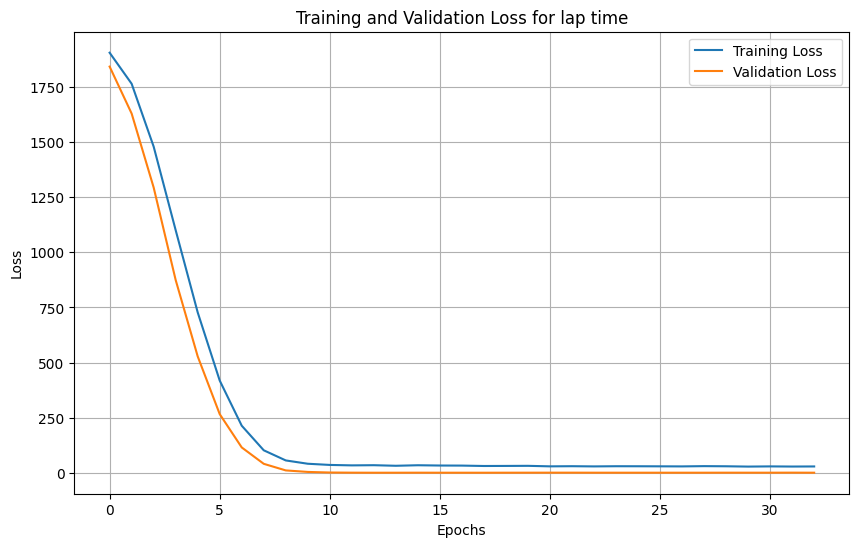

Neural Network Performance:
  Test Loss: 0.8632
  RMSE: 0.9317
  MAE: 0.6692
  R²: 0.7330


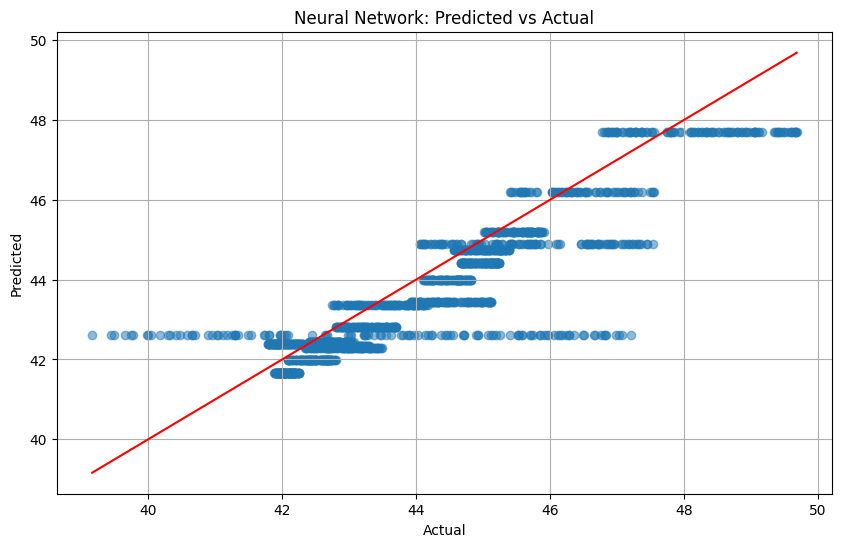

Results for lap time: {'rmse': np.float64(0.9317099107613775), 'mae': 0.6692399382591248, 'r2': 0.7329671382904053}
Training NN for average_speed prediction...
Using device: cuda
Epoch 1/200, Train Loss: 224.1199, Val Loss: 209.4816
Epoch 2/200, Train Loss: 181.7635, Val Loss: 147.7254
Epoch 3/200, Train Loss: 107.6470, Val Loss: 69.7495
Epoch 4/200, Train Loss: 43.9305, Val Loss: 19.8502
Epoch 5/200, Train Loss: 13.9565, Val Loss: 4.0303
Epoch 6/200, Train Loss: 7.0700, Val Loss: 0.8901
Epoch 7/200, Train Loss: 5.7669, Val Loss: 0.4962
Epoch 8/200, Train Loss: 5.5399, Val Loss: 0.3825
Epoch 9/200, Train Loss: 5.1539, Val Loss: 0.3702
Epoch 10/200, Train Loss: 4.8703, Val Loss: 0.3656
Epoch 11/200, Train Loss: 4.5168, Val Loss: 0.3543
Epoch 12/200, Train Loss: 4.6181, Val Loss: 0.3191
Epoch 13/200, Train Loss: 4.3295, Val Loss: 0.3479
Epoch 14/200, Train Loss: 4.1705, Val Loss: 0.3485
Epoch 15/200, Train Loss: 3.9673, Val Loss: 0.3184
Epoch 16/200, Train Loss: 4.0757, Val Loss: 0.3160


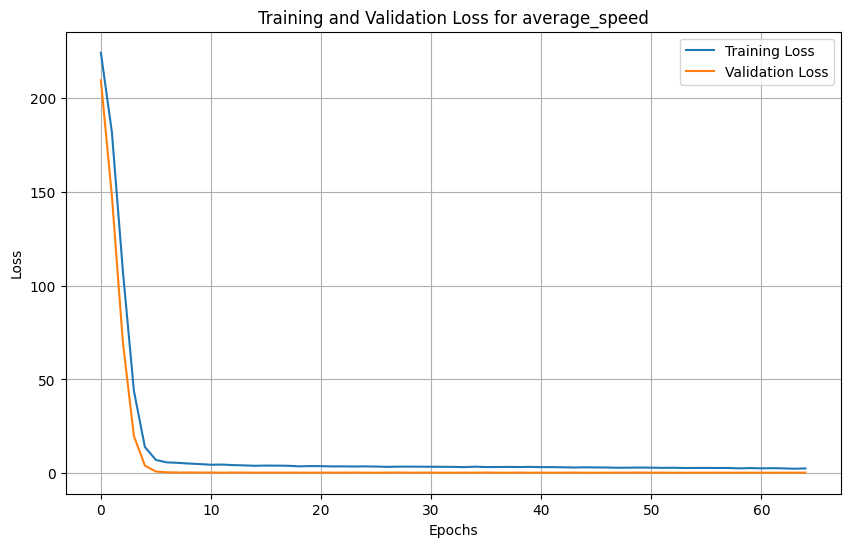

Neural Network Performance:
  Test Loss: 0.2577
  RMSE: 0.5087
  MAE: 0.3960
  R²: 0.1819


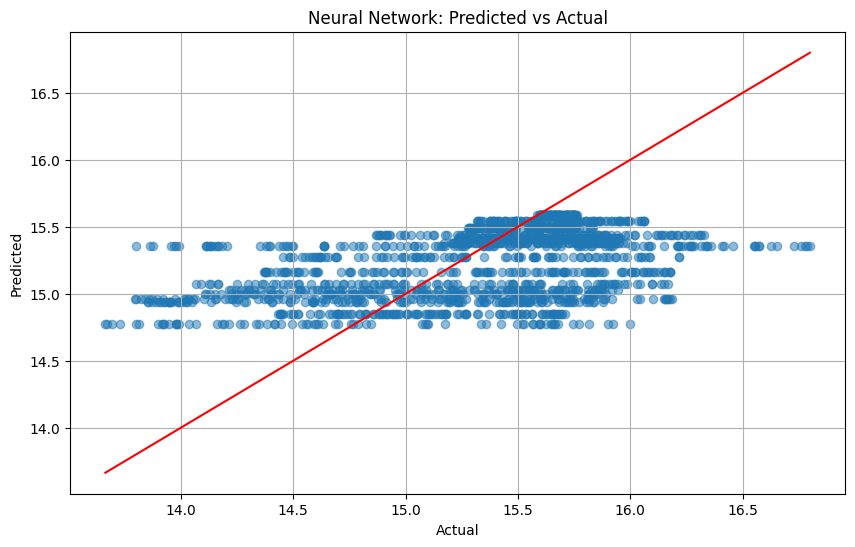

Results for average_speed: {'rmse': np.float64(0.5086866337916096), 'mae': 0.39600589871406555, 'r2': 0.1819111704826355}


In [133]:
data_path = 'Data.csv'

# Loop through each target
for target_name in ['fuel_consumption', 'lap time', 'average_speed']:
    print(f"Training NN for {target_name} prediction...")
    model, preprocessor, results = nn_pipeline(data_path, target_name)
    print(f"Results for {target_name}: {results}")

    # Save the model and preprocessor 
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_size': model.model[0].in_features
    }, f'{target_name.replace(" ", "_")}_nn_model.pth')


## With Embeddings

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Neural network model with embeddings
class RegressionNN(nn.Module):
    def __init__(self, num_numerical_features, num_vehicle_brands, num_vehicle_types, 
                 embedding_dim_brands=8, embedding_dim_types=4):
        super(RegressionNN, self).__init__()
        
        # Embedding layers
        self.brand_embedding = nn.Embedding(num_vehicle_brands, embedding_dim_brands)
        self.type_embedding = nn.Embedding(num_vehicle_types, embedding_dim_types)

        # Fully connected layers for numerical features
        self.num_fc = nn.Sequential(
            nn.Linear(num_numerical_features, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )

        # Combined layers
        combined_dim = 32 + embedding_dim_brands + embedding_dim_types
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, numerical_input, brand_input, type_input):
        # Get embeddings
        brand_emb = self.brand_embedding(brand_input)
        type_emb = self.type_embedding(type_input)
        
        # Process numerical features
        num_features = self.num_fc(numerical_input)
        
        # Concatenate all features
        combined = torch.cat([
            num_features, 
            brand_emb.squeeze(1), 
            type_emb.squeeze(1)
        ], dim=1)
        
        # Final layers
        output = self.fc(combined)
        return output


In [135]:
def train_nn_with_embeddings(model, train_loader, val_loader, criterion, optimizer, 
                             device, epochs=100, patience=10):
    model.to(device)
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for num_features, brand_ids, type_ids, targets in train_loader:
            num_features = num_features.to(device)
            brand_ids = brand_ids.to(device)
            type_ids = type_ids.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(num_features, brand_ids, type_ids)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for num_features, brand_ids, type_ids, targets in val_loader:
                num_features = num_features.to(device)
                brand_ids = brand_ids.to(device)
                type_ids = type_ids.to(device)
                targets = targets.to(device)
                
                outputs = model(num_features, brand_ids, type_ids)
                val_loss = criterion(outputs, targets)
                running_val_loss += val_loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model_with_embeddings.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    model.load_state_dict(torch.load('best_model_with_embeddings.pth'))
    return model, train_losses, val_losses

In [136]:
def evaluate_nn_with_embeddings(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_targets = []
    test_loss = 0.0
    
    with torch.no_grad():
        for num_features, brand_ids, type_ids, targets in test_loader:
            num_features = num_features.to(device)
            brand_ids = brand_ids.to(device)
            type_ids = type_ids.to(device)
            targets = targets.to(device)
            
            outputs = model(num_features, brand_ids, type_ids)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    all_preds = np.array(all_preds).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)
    
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    print(f"Neural Network Performance:")
    print(f"  Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Neural Network with Embeddings: Predicted vs Actual')
    plt.grid(True)
    plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [137]:
from torch.utils.data import Dataset, DataLoader

# Custom dataset for handling numerical and categorical features separately
class VehicleEmbeddingDataset(Dataset):
    def __init__(self, numerical_features, brand_ids, type_ids, targets):
        self.numerical_features = torch.FloatTensor(numerical_features)
        self.brand_ids = torch.LongTensor(brand_ids)
        self.type_ids = torch.LongTensor(type_ids)
        self.targets = torch.FloatTensor(targets.reshape(-1, 1))
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return (
            self.numerical_features[idx], 
            self.brand_ids[idx], 
            self.type_ids[idx], 
            self.targets[idx]
        )

In [138]:
def nn_pipeline_with_embeddings(data_path, target_name):
    # Load data
    df = pd.read_csv(data_path)
    
    # Add brand feature
    df['vehicle_brand'] = df['vehicle_name'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else 'unknown')
    df['fuel_consumption'] *= 1000
    df['lap time'] /= 10
    
    df = df.drop(
    columns=[
        'mass','center_of_mass_z'] ,errors="ignore",
    )

    categorical_features = ['vehicle_brand', 'vehicle_type']

    # Select features
   
    numerical_features = ['drag_coefficient', 'front_left_wheel_lat_stiff_max_load', 'front_left_wheel_lat_stiff_value', 
                          'front_right_wheel_lat_stiff_value', 'lap', 'rear_left_wheel_lat_stiff_max_load', 
                          'rear_left_wheel_lat_stiff_value', 'rear_right_wheel_lat_stiff_value',
                          'total_brake', 'velocity','front_left_wheel_long_stiff_value',
        'front_left_wheel_position_x', 'front_left_wheel_position_y',
       'front_left_wheel_position_z', 'front_right_wheel_long_stiff_value',
       'front_right_wheel_position_z', 'rear_left_wheel_radius',
       'rear_left_wheel_max_handbrake_torque',
       'rear_left_wheel_long_stiff_value', 'rear_left_wheel_position_y', 'gear_switch_time', 'front_left_wheel_radius',
       'front_left_wheel_max_brake_torque', 'front_right_wheel_radius',
       'front_right_wheel_max_brake_torque', 'front_right_wheel_position_x',
       'front_right_wheel_position_y', 'rear_left_wheel_max_brake_torque',
       'rear_left_wheel_position_z', 'rear_right_wheel_radius',
       'rear_right_wheel_max_brake_torque',
       'rear_right_wheel_max_handbrake_torque', 'total_steering', 'total_throttle',
       'center_of_mass_x', 'clutch_strength','max_rpm', 'front_left_wheel_max_steer_angle',
       'front_right_wheel_max_steer_angle',
       'front_right_wheel_lat_stiff_max_load', 'rear_left_wheel_position_x',
       'rear_right_wheel_lat_stiff_max_load',
       'rear_right_wheel_long_stiff_value', 'rear_right_wheel_position_x',
       'rear_right_wheel_position_y', 'rear_right_wheel_position_z']

    # Split data
    X_num = df[numerical_features]
    X_cat = df[categorical_features]
    y = df[target_name].values
    
    # Create mappings for categorical features
    brand_mapping = {brand: idx for idx, brand in enumerate(X_cat['vehicle_brand'].unique())}
    type_mapping = {type_: idx for idx, type_ in enumerate(X_cat['vehicle_type'].unique())}
    
    # Convert categorical features to IDs
    brand_ids = X_cat['vehicle_brand'].map(brand_mapping).values
    type_ids = X_cat['vehicle_type'].map(type_mapping).values
    
    # Scale numerical features
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    
    # Split data using indices to ensure alignment
    indices = np.arange(len(df))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
    train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)
    
    # Get data using indices
    X_train_num = X_num_scaled[train_indices]
    X_val_num = X_num_scaled[val_indices]
    X_test_num = X_num_scaled[test_indices]
    
    X_train_brand = brand_ids[train_indices]
    X_val_brand = brand_ids[val_indices]
    X_test_brand = brand_ids[test_indices]
    
    X_train_type = type_ids[train_indices]
    X_val_type = type_ids[val_indices]
    X_test_type = type_ids[test_indices]
    
    y_train = y[train_indices]
    y_val = y[val_indices]
    y_test = y[test_indices]
    
    # Create PyTorch datasets
    train_dataset = VehicleEmbeddingDataset(X_train_num, X_train_brand, X_train_type, y_train)
    val_dataset = VehicleEmbeddingDataset(X_val_num, X_val_brand, X_val_type, y_val)
    test_dataset = VehicleEmbeddingDataset(X_test_num, X_test_brand, X_test_type, y_test)
    
    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model with embeddings
    model = RegressionNN(
        num_numerical_features=len(numerical_features),
        num_vehicle_brands=len(brand_mapping),
        num_vehicle_types=len(type_mapping)
    )
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Train model
    model, train_losses, val_losses = train_nn_with_embeddings(
        model, train_loader, val_loader, criterion, optimizer, device, epochs=150, patience=15
    )
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {target_name} (with Embeddings)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluate model
    results = evaluate_nn_with_embeddings(model, test_loader, criterion, device)
    
    # Save the mappings for future use
    mappings = {
        'brand_mapping': brand_mapping,
        'type_mapping': type_mapping
    }
    
    return model, scaler, mappings, results

### Running the model

Using device: cuda
Epoch 1/150, Train Loss: 11.1197, Val Loss: 2.1877
Epoch 2/150, Train Loss: 0.9375, Val Loss: 0.0452
Epoch 3/150, Train Loss: 0.5079, Val Loss: 0.0393
Epoch 4/150, Train Loss: 0.4351, Val Loss: 0.0291
Epoch 5/150, Train Loss: 0.3697, Val Loss: 0.0309
Epoch 6/150, Train Loss: 0.3348, Val Loss: 0.0208
Epoch 7/150, Train Loss: 0.3032, Val Loss: 0.0369
Epoch 8/150, Train Loss: 0.2738, Val Loss: 0.0251
Epoch 9/150, Train Loss: 0.2539, Val Loss: 0.0195
Epoch 10/150, Train Loss: 0.2681, Val Loss: 0.0334
Epoch 11/150, Train Loss: 0.2492, Val Loss: 0.0262
Epoch 12/150, Train Loss: 0.2296, Val Loss: 0.0288
Epoch 13/150, Train Loss: 0.2243, Val Loss: 0.0378
Epoch 14/150, Train Loss: 0.2232, Val Loss: 0.0248
Epoch 15/150, Train Loss: 0.2261, Val Loss: 0.0192
Epoch 16/150, Train Loss: 0.2121, Val Loss: 0.0216
Epoch 17/150, Train Loss: 0.1998, Val Loss: 0.0363
Epoch 18/150, Train Loss: 0.1944, Val Loss: 0.0240
Epoch 19/150, Train Loss: 0.1923, Val Loss: 0.0256
Epoch 20/150, Train 

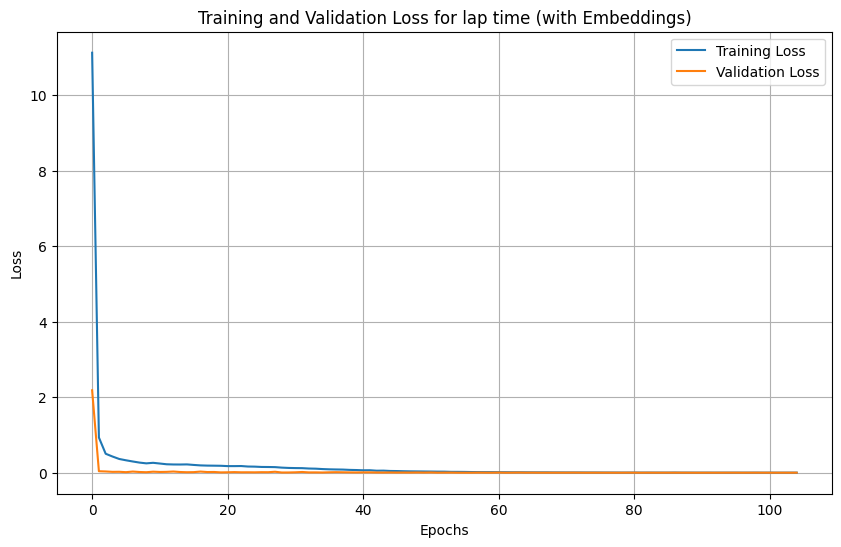

Neural Network Performance:
  Test Loss: 0.0059
  RMSE: 0.0769
  MAE: 0.0448
  R²: 0.8180


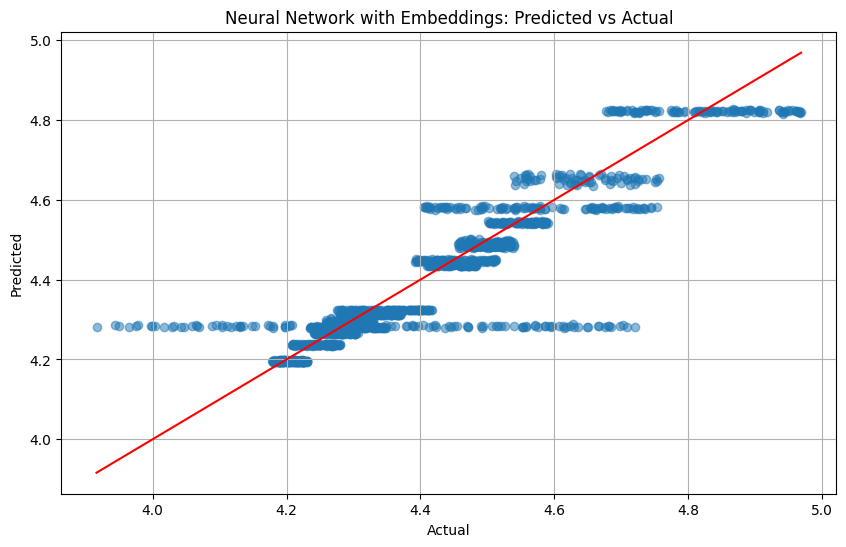


Results for lap time prediction with embeddings:
RMSE: 0.0769
MAE: 0.0448
R²: 0.8180
Using device: cuda
Epoch 1/150, Train Loss: 54.0141, Val Loss: 18.8845
Epoch 2/150, Train Loss: 11.9207, Val Loss: 2.5360
Epoch 3/150, Train Loss: 4.7516, Val Loss: 0.9525
Epoch 4/150, Train Loss: 4.2514, Val Loss: 1.3993
Epoch 5/150, Train Loss: 4.4318, Val Loss: 1.0265
Epoch 6/150, Train Loss: 3.7237, Val Loss: 1.0560
Epoch 7/150, Train Loss: 4.3282, Val Loss: 0.8909
Epoch 8/150, Train Loss: 3.8855, Val Loss: 0.8714
Epoch 9/150, Train Loss: 3.7193, Val Loss: 1.2530
Epoch 10/150, Train Loss: 3.3611, Val Loss: 1.0935
Epoch 11/150, Train Loss: 3.2920, Val Loss: 0.9223
Epoch 12/150, Train Loss: 3.0963, Val Loss: 0.9143
Epoch 13/150, Train Loss: 3.0476, Val Loss: 0.8914
Epoch 14/150, Train Loss: 2.6949, Val Loss: 0.8568
Epoch 15/150, Train Loss: 2.8228, Val Loss: 1.2765
Epoch 16/150, Train Loss: 2.7504, Val Loss: 1.0667
Epoch 17/150, Train Loss: 2.6132, Val Loss: 0.8596
Epoch 18/150, Train Loss: 2.5053, 

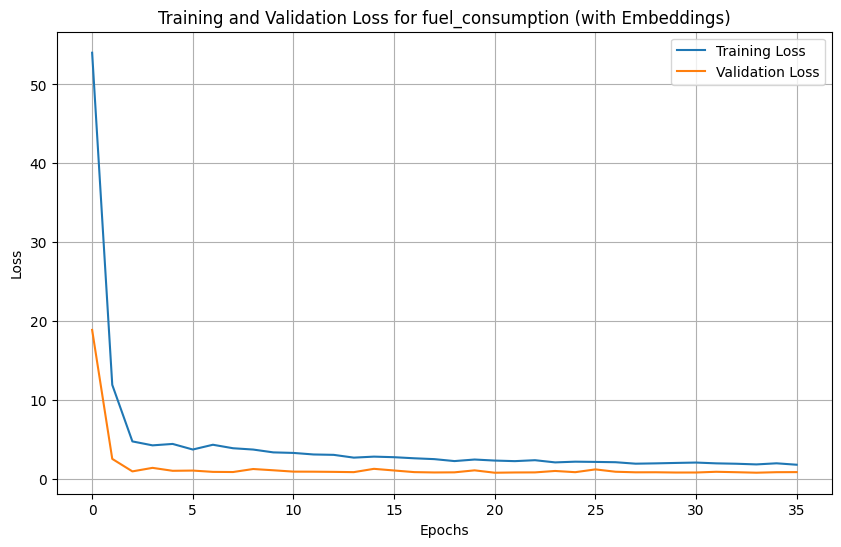

Neural Network Performance:
  Test Loss: 0.8049
  RMSE: 0.8985
  MAE: 0.6953
  R²: 0.9813


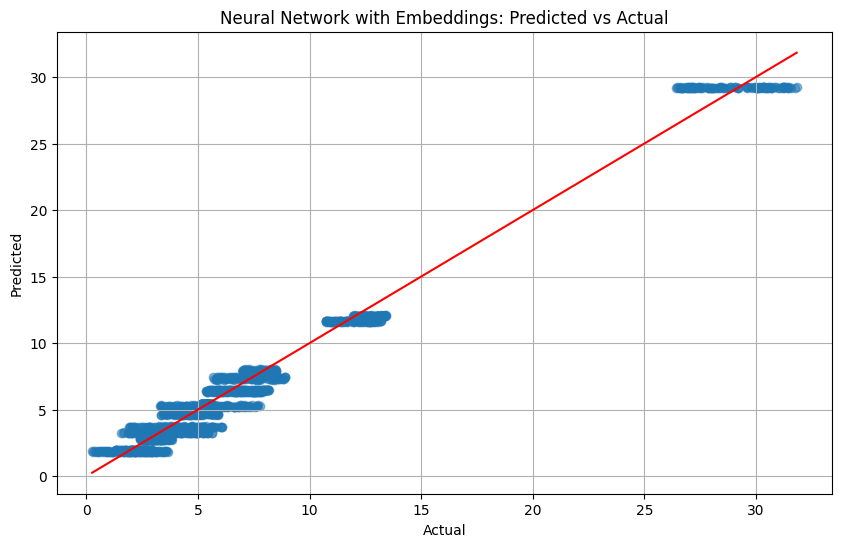


Results for fuel_consumption prediction with embeddings:
RMSE: 0.8985
MAE: 0.6953
R²: 0.9813
Using device: cuda
Epoch 1/150, Train Loss: 211.1121, Val Loss: 162.9707
Epoch 2/150, Train Loss: 108.5008, Val Loss: 41.0791
Epoch 3/150, Train Loss: 18.6512, Val Loss: 1.3897
Epoch 4/150, Train Loss: 7.0932, Val Loss: 0.6043
Epoch 5/150, Train Loss: 6.3632, Val Loss: 0.4748
Epoch 6/150, Train Loss: 7.4039, Val Loss: 1.3983
Epoch 7/150, Train Loss: 6.4941, Val Loss: 0.7346
Epoch 8/150, Train Loss: 6.1474, Val Loss: 0.5741
Epoch 9/150, Train Loss: 5.3961, Val Loss: 0.4812
Epoch 10/150, Train Loss: 6.3279, Val Loss: 0.6727
Epoch 11/150, Train Loss: 5.2001, Val Loss: 0.7150
Epoch 12/150, Train Loss: 5.6745, Val Loss: 0.5045
Epoch 13/150, Train Loss: 5.3061, Val Loss: 0.6769
Epoch 14/150, Train Loss: 5.8609, Val Loss: 0.5571
Epoch 15/150, Train Loss: 5.8940, Val Loss: 0.6149
Epoch 16/150, Train Loss: 5.2936, Val Loss: 0.4745
Epoch 17/150, Train Loss: 4.8978, Val Loss: 0.5872
Epoch 18/150, Train L

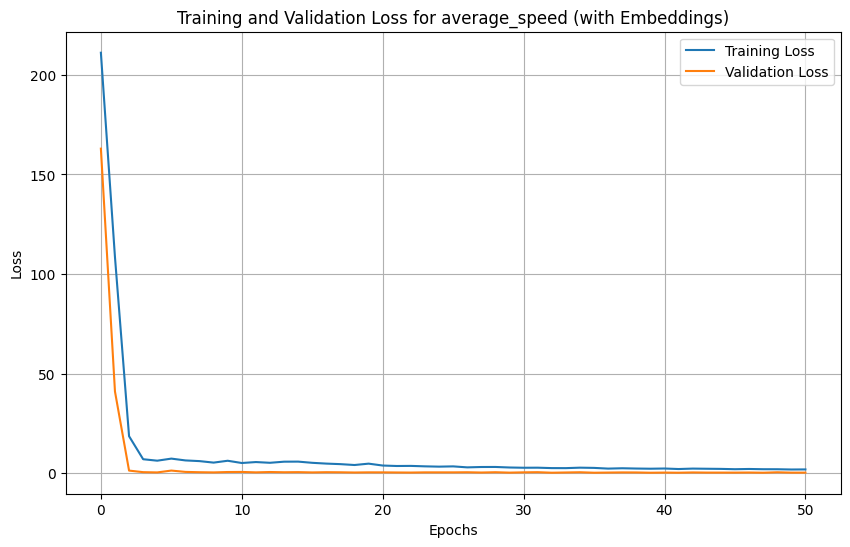

Neural Network Performance:
  Test Loss: 0.3241
  RMSE: 0.5682
  MAE: 0.4773
  R²: -0.0208


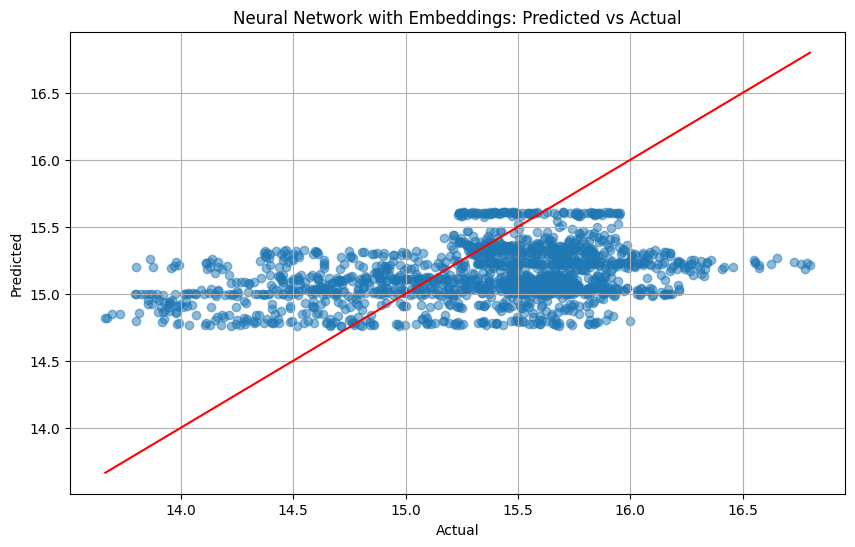


Results for average_speed prediction with embeddings:
RMSE: 0.5682
MAE: 0.4773
R²: -0.0208


In [139]:
data_path = 'Data.csv'
target_names =['lap time','fuel_consumption', 'average_speed']

for target in target_names:
    model, scaler, mappings, results = nn_pipeline_with_embeddings(data_path, target)
    # Print results
    print(f"\nResults for {target} prediction with embeddings:")
    print(f"RMSE: {results['rmse']:.4f}")
    print(f"MAE: {results['mae']:.4f}")
    print(f"R²: {results['r2']:.4f}")
